<a href="https://colab.research.google.com/github/phamduyhk/stock-info/blob/master/lstmgooglecolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import xgboost as xgb
import numpy as np
import sys
import os
import configparser
from os import path
import sys
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
import datetime
import glob
import json

import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

## for Deep-learing:
import keras
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [0]:
files = glob.glob('./*.xls')
print(files)
hose = pd.read_excel('./HOSE.xls',index_col=False, encoding="utf-8")
index = pd.read_excel('./Index.xls', index_col=False, encoding="utf-8")

['./HNX.xls', './UPCOM.xls', './Index.xls', './HOSE.xls']


In [0]:
vnindex = index.loc[index.TICKER=='VNINDEX',: ]

In [0]:
df = vnindex['OPEN'].values
df = df.reshape(-1,1)
print(df.shape)

(1118, 1)


In [0]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50,df.shape[0]):
        x.append(df[i-50:i,])
        y.append(df[i])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [0]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(894, 1)
(274, 1)


In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.04924694],
       [0.04012979],
       [0.05356861],
       [0.06081925],
       [0.06374822]])

In [0]:
dataset_test = scaler.fit_transform(dataset_test)
print(dataset_test.shape)
dataset_test[:5]

(274, 1)


array([[0.21468518],
       [0.35166787],
       [0.4585828 ],
       [0.43516021],
       [0.38706494]])

In [0]:
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)
print(x_test.shape)

(224, 50, 1)


In [0]:
def dataset_to_array(dataset):
  array = dataset[0,:,:]
  for i in range(1,dataset.shape[0]):
    array = np.append(array,dataset[i,49,:])
  return array

test = dataset_to_array(x_test)
# for i in range(273):
#   print(dataset_test[i,:]-test[i])

print(dataset_test[273,:])
print(dataset_test[272,:])
print(test[272])

[0.70767814]
[0.69399303]
0.6939930258569638


In [0]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


AttributeError: ignored

In [0]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print("")
        print(".", end="")

In [0]:
# Model building
length_of_sequence = x_train.shape[1]
in_out_neurons = 1
n_hidden = 128
 
model = Sequential()
# model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=True))
model.add(LSTM(n_hidden,  return_sequences=True))
model.add(LSTM(n_hidden, return_sequences=False))
model.add(Dense(in_out_neurons))
# model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)
model.summary()

#early stop
early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=10)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50, 128)           66560     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 128)           131584    
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________
[[0.90216434]
 [0.88947344]
 [0.8939533 ]
 [0.93258965]
 [0.95092684]]


In [0]:
# load model parameters
if os.path.isfile("param_goto.hdf5"):
    model.load_weights('param_goto.hdf5')
# Learning 
history = model.fit(x_train, y_train,batch_size = 32, epochs=100, validation_split=0.1, verbose=0,
                    callbacks=[early_stop,PrintDot()])

In [0]:
# Predict
predicted = model.predict(x_test)
print(predicted[:5])

[[0.90216434]
 [0.88947344]
 [0.8939533 ]
 [0.93258965]
 [0.95092684]]


In [0]:
json_string = model.to_json()
with open('model_goto.json', 'w') as outfile:
    json.dump(json_string, outfile)

#save weight
model.save_weights('param_goto.hdf5')

In [0]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.plot(hist["epoch"], hist["loss"], label="Train loss")
    plt.plot(hist["epoch"], hist["val_loss"], label="Val loss")
    plt.legend()
#     plt.ylim([0, 5])

    # plt.figure()
    # plt.xlabel("Epoch")
    # plt.ylabel("Mean Abs Percentage Error")
    # plt.plot(hist["epoch"], hist["mean_absolute_percentage_error"], label="Train Error")
    # plt.plot(hist["epoch"], hist["val_mean_absolute_percentage_error"], label="Val Error")
    # plt.legend()
#     plt.ylim([0, 20])



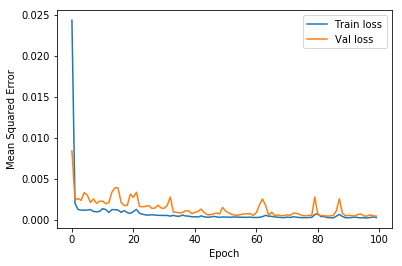

In [0]:
plot_history(history)
# print(history.history)

[[0.90216434]
 [0.88947344]
 [0.8939533 ]
 [0.93258965]
 [0.95092684]]
[[0.89637476]
 [0.92032371]
 [0.96486611]
 [0.96585302]
 [0.93144286]]
(224,)


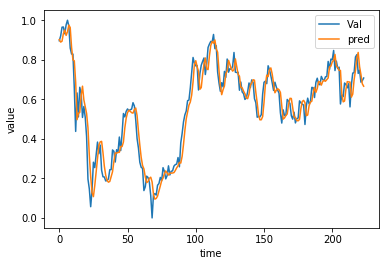

In [0]:
predicted = model.predict(x_test)
value = scaler.inverse_transform(predicted)
test = dataset_test[50:-1,:]
# test = dataset_train[50:-1,:]
test = scaler.inverse_transform(test)
print(value[:5])
print(test[:5])
test = np.append(test,dataset_test[-1,:])
print(test.shape)
truc_x = []
for i in range(test.shape[0]):
  truc_x.append(i)


plt.figure()
plt.xlabel("time")
plt.ylabel("value")
plt.plot(truc_x, test, label="Val")
plt.plot(truc_x, value, label="pred")
plt.legend()


In [0]:
x = x_test[-4:,:,:]
print(x.shape)

In [0]:
p = model.predict(x)
print(scaler.inverse_transform(p))

[[988.4757 ]
 [982.27795]
 [975.39087]
 [973.6163 ]]


In [0]:
print(scaler.inverse_transform(x_test[-50:,:,:]))

ValueError: ignored